In [2]:
### IMPORT LIBRARIES
##### Built in libraries
import os

###### Use pip or anaconda to install
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [3]:
### READ DATA
##### Needs to be ran from the project directory
csv_measurements = os.path.join(os.getcwd(), 'datasets', 'measurements.csv')
df_measurements = pd.read_csv(csv_measurements, parse_dates=['measurement_time'])
df_measurements = df_measurements.sort_values(by=['measurement_time'], ascending=[True])

csv_failures = os.path.join(os.getcwd(), 'datasets', 'failures.csv')
df_failures = pd.read_csv(csv_failures, parse_dates=['failure_time'])
df_failures = df_failures.sort_values(by=['failure_time'], ascending=[True])

print(df_measurements)
print(df_failures)

            measurement_time  gadget_id  vibration_x  vibration_y  pressure  \
0    2020-07-15 00:00:00.000          1            3            7      16.0   
336  2020-07-15 00:00:00.000          3            3            8      11.0   
168  2020-07-15 00:00:00.000          2            3           10      16.0   
840  2020-07-15 00:00:00.000          6            7            6      12.0   
672  2020-07-15 00:00:00.000          5            4            7      12.0   
...                      ...        ...          ...          ...       ...   
671  2020-07-21 22:59:59.505          4            6            6      19.0   
335  2020-07-21 22:59:59.505          2            2            4      15.0   
167  2020-07-21 22:59:59.505          1            6            5      12.0   
839  2020-07-21 22:59:59.505          5            1            2      19.0   
1007 2020-07-21 22:59:59.505          6            4            4      19.0   

      temperature  Unnamed: 10  Unnamed: 11  
0    

In [4]:
### MERGE NEXT FAILURE TO MEASUREMENTS
df_combined = pd.merge_asof(
    df_measurements,
    df_failures,
    left_on='measurement_time',
    right_on='failure_time',
    by='gadget_id',
    direction='forward',
)
df_combined

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640
1,2020-07-15 00:00:00.000,3,3,8,11.0,40.427740,NaN,NaN,2020-07-15 09:33:48.330967860
2,2020-07-15 00:00:00.000,2,3,10,16.0,22.300000,NaN,NaN,2020-07-15 07:11:50.319233260
3,2020-07-15 00:00:00.000,6,7,6,12.0,75.874521,NaN,NaN,2020-07-16 16:05:31.427141800
4,2020-07-15 00:00:00.000,5,4,7,12.0,81.125342,NaN,NaN,2020-07-15 05:48:58.383388460
...,...,...,...,...,...,...,...,...,...
1003,2020-07-21 22:59:59.505,4,6,6,19.0,85.023812,NaN,NaN,NaT
1004,2020-07-21 22:59:59.505,2,2,4,15.0,42.221386,NaN,NaN,NaT
1005,2020-07-21 22:59:59.505,1,6,5,12.0,11.773688,NaN,NaN,NaT
1006,2020-07-21 22:59:59.505,5,1,2,19.0,78.867472,NaN,NaN,NaT


In [5]:
### TRANSFORM COLUMNS
df_combined['time_to_fail'] = df_combined['failure_time']-df_combined['measurement_time']
df_combined['fail_in_1h'] = np.where(df_combined['time_to_fail']<pd.Timedelta(hours=1), 1, 0)
df_combined

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,fail_in_1h
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 09:56:03.974006640,0
1,2020-07-15 00:00:00.000,3,3,8,11.0,40.427740,NaN,NaN,2020-07-15 09:33:48.330967860,0 days 09:33:48.330967860,0
2,2020-07-15 00:00:00.000,2,3,10,16.0,22.300000,NaN,NaN,2020-07-15 07:11:50.319233260,0 days 07:11:50.319233260,0
3,2020-07-15 00:00:00.000,6,7,6,12.0,75.874521,NaN,NaN,2020-07-16 16:05:31.427141800,1 days 16:05:31.427141800,0
4,2020-07-15 00:00:00.000,5,4,7,12.0,81.125342,NaN,NaN,2020-07-15 05:48:58.383388460,0 days 05:48:58.383388460,0
...,...,...,...,...,...,...,...,...,...,...,...
1003,2020-07-21 22:59:59.505,4,6,6,19.0,85.023812,NaN,NaN,NaT,NaT,0
1004,2020-07-21 22:59:59.505,2,2,4,15.0,42.221386,NaN,NaN,NaT,NaT,0
1005,2020-07-21 22:59:59.505,1,6,5,12.0,11.773688,NaN,NaN,NaT,NaT,0
1006,2020-07-21 22:59:59.505,5,1,2,19.0,78.867472,NaN,NaN,NaT,NaT,0


In [6]:
### CALCULATE RUNNING MEASURES
df_combined = df_combined.reset_index(drop=True)
df_combined = df_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])
df_combined['temperature_6h_std'] = df_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
df_combined['pressure_6h_mean'] = df_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)
df_combined

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,fail_in_1h,temperature_6h_std,pressure_6h_mean
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 09:56:03.974006640,0,NaN,NaN
7,2020-07-15 01:00:00.000,1,8,3,12.0,34.395177,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 08:56:03.974006640,0,3.453742,15.500000
13,2020-07-15 01:59:59.990,1,10,8,20.0,38.280705,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 07:56:03.984006640,0,3.803752,16.833333
18,2020-07-15 02:59:59.985,1,6,5,20.0,41.878215,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 06:56:03.989006640,0,3.679122,15.166667
25,2020-07-15 03:59:59.980,1,6,9,16.0,39.257268,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 05:56:03.994006640,0,9.337838,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,2020-07-21 18:59:59.505,6,6,5,10.0,71.493668,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 02:55:15.958450739,0,2.523321,14.750000
989,2020-07-21 19:59:59.505,6,6,4,15.0,68.088351,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 01:55:15.958450739,0,4.888758,14.750000
992,2020-07-21 20:59:59.505,6,7,8,11.0,79.375957,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 00:55:15.958450739,1,3.862833,15.000000
998,2020-07-21 21:59:59.505,6,6,7,16.0,80.754416,NaN,NaN,2020-07-21 22:09:51.002875980,0 days 00:09:51.497875980,1,5.541126,14.916667


In [7]:
### SPLIT TO TRAIN AND TEST
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = 'fail_in_1h'
cols = X + [y]

df_to_split = df_combined.copy()
df_to_split = df_to_split.dropna(subset=cols)
df_to_split = df_to_split.reset_index(drop=True)

In [8]:
##### Create binary bins to 
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
binner.fit(df_to_split[X])
arr_bins= binner.transform(df_to_split[X])
df_bins = pd.DataFrame(arr_bins)

X = list(df_bins.columns)
cols = X + [y]

df_to_split = pd.concat([df_to_split, df_bins], axis=1)

df_train = df_to_split[df_to_split['gadget_id'].isin([1,2,3,4])].reset_index(drop=True).copy()
df_test = df_to_split[df_to_split['gadget_id'].isin([5,6])].reset_index(drop=True).copy()

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

Training data: (651, 43)
Test data: (327, 43)


In [9]:
### PREDICTION PARAMETERS
w0 = 1
w1 = 8
pos_label = 1

In [10]:
### NEURAL NETWORK
nn = MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(10),
    random_state=1,
    max_iter=10000,
    activation='relu',
    tol=0.00001,
)
nn.fit(df_train[X], df_train[y])
df_test['nn'] = nn.predict(df_test[X])

In [11]:
### RANDOM FOREST MODEL
random_forest = RandomForestClassifier(
    min_samples_leaf=7,
    random_state=45,
    n_estimators=50,
    class_weight={0:w0, 1:w1}
)
random_forest.fit(df_train[X], df_train[y])
df_test['random_forest'] = random_forest.predict(df_test[X])

In [12]:
### LOGISTIC REGRESSION MODEL
log_regr = LogisticRegression(class_weight={0:w0, 1:w1})
log_regr.fit(df_train[X], df_train[y])
df_test['log_regr'] = log_regr.predict(df_test[X])

In [13]:
### LINEAR REGRESSION MODEL
lin_regr = Lasso(alpha=0.1, positive=True)
lin_regr.fit(df_train[X], df_train[y])
df_test['lin_regr'] = lin_regr.predict(df_test[X])
df_test['lin_regr'] = np.where(df_test['lin_regr']>=0.5,1,0)

In [14]:
### KNN MODEL
def knn_weights(knn_y):
    return np.where(knn_y==1, w1, w0)
knn = KNeighborsClassifier(weights=knn_weights)
knn.fit(df_train[X], df_train[y])
df_test['knn'] = knn.predict(df_test[X])

In [15]:
### SVM
svm = SVC(
    class_weight={0:w0, 1:w1},
    C=1,
    random_state=42,
    kernel='linear'
)
svm.fit(df_train[X], df_train[y])
df_test['svm'] = svm.predict(df_test[X])

In [16]:
### NAIVE BAYES
bayes = GaussianNB()
bayes.fit(df_train[X], df_train[y])
df_test['bayes'] = bayes.predict(df_test[X])

In [17]:
### PRINT RESULTS
model_summary = []
models = ['random_forest', 'log_regr', 'lin_regr', 'knn', 'nn', 'svm', 'bayes']
for m in models:
    print(f"\n-----------\n{m}")
    try:
        precision = precision_score(df_test['fail_in_1h'], df_test[m], zero_division=0, pos_label=pos_label)
        recall = recall_score(df_test['fail_in_1h'], df_test[m], pos_label=pos_label)
        
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(df_test[m].value_counts())

        model_summary.append({
            'model': m,
            'precision': precision,
            'recall': recall
        })

    except:
        print("Can't calculate score")


-----------
random_forest
Precision: 0.3106796116504854
Recall: 1.0
0    224
1    103
Name: random_forest, dtype: int64

-----------
log_regr
Precision: 0.3
Recall: 0.9375
0    227
1    100
Name: log_regr, dtype: int64

-----------
lin_regr
Precision: 0.0
Recall: 0.0
0    327
Name: lin_regr, dtype: int64

-----------
knn
Precision: 0.2857142857142857
Recall: 0.0625
0    320
1      7
Name: knn, dtype: int64

-----------
nn
Precision: 0.3
Recall: 0.09375
0    317
1     10
Name: nn, dtype: int64

-----------
svm
Precision: 0.30303030303030304
Recall: 0.9375
0    228
1     99
Name: svm, dtype: int64

-----------
bayes
Precision: 0.30303030303030304
Recall: 0.9375
0    228
1     99
Name: bayes, dtype: int64


In [18]:
#PRINT RESULT DATAFRAME
print(df_test[['gadget_id', 'measurement_time'] + cols + models].head(5))

   gadget_id        measurement_time    0    1    2    3    4    5    6    7  \
0          5 2020-07-15 01:00:00.000  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1          5 2020-07-15 01:59:59.990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2          5 2020-07-15 02:59:59.985  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3          5 2020-07-15 03:59:59.980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4          5 2020-07-15 04:59:59.975  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...   28   29  fail_in_1h  random_forest  log_regr  lin_regr  knn  nn  svm  \
0  ...  0.0  0.0           0              0         0         0    0   0    0   
1  ...  0.0  0.0           0              1         1         0    0   0    1   
2  ...  0.0  0.0           0              0         0         0    0   0    0   
3  ...  0.0  0.0           0              1         1         0    0   1    1   
4  ...  0.0  0.0           1              1         1         0    1   1    1   

   bayes  
0      0  
1      1  

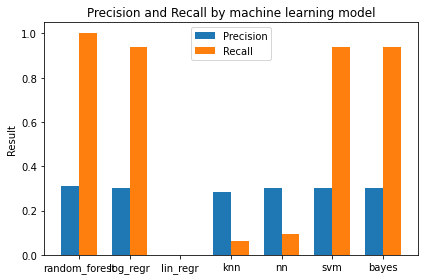

In [20]:
#CREATE IMAGE FOR MODEL COMPARISON
df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_summary['precision'], width, label='Precision')
rects2 = ax.bar(x + width/2, df_summary['recall'], width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_title('Precision and Recall by machine learning model')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
ax.legend()

fig.tight_layout()

plt.savefig('..\\img\\results.png')